## Extraindo uma playlist de um usuário

In [234]:
import os
import json
import pandas as pd
import numpy as np
import io
import requests
import subprocess 
from numpy import array
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [50]:
# generate authorization token
def generate_token():
    with open('auth.json') as json_file:  
            data = json.load(json_file)

    auth_64 = data["auth_id"]
    
    
    cmd = ('curl -X "POST" -H "Authorization: Basic {0}" -d grant_type=client_credentials https://accounts.spotify.com/api/token').format(auth_64)

    output = subprocess.check_output(cmd,shell=True)
    tmp = json.loads(output)
    
    return(tmp["access_token"])

# get the playlist id from playlist link
def playlist_extrator(link):
    link = str(link)
    link = link.split('/')
    username = ''
    playlist_id = ''
    for i in range(0,len(link)):
        if link[i] == 'user':
            username = link[i+1]
        elif link[i] == 'playlist':
            playlist_id = link[i+1]
        
    return (username,playlist_id)
# request the playlist info
def generate_request(auth,playlist_link):
    username,playlist_id = playlist_extrator(playlist_link)
    link = ('curl -X GET "https://api.spotify.com/v1/users/{0}/playlists/{1}/tracks?market=BR" -H "Accept: application/json" -H "Authorization: Bearer {2}"'.format(username,playlist_id,auth))
    return link




In [51]:
# lists the musics from a playlist
def list_music(auth,playlist_link):
    
    link  = generate_request(auth,playlist_link)
    output = subprocess.check_output(link,shell=True)
    obj = json.loads(output)
    music = ''
    try:
        for values in obj['tracks']['items']:
            if values['track']['id'] != None:
                music += values['track']['id'] +','
    except:

        for items in obj['items']:
            if items['track']['id'] != None:
                music += items['track']['id'] +','
                
    return music

# get dictionary of music from list of ids

def get_music_from_id(auth,music_list): 
    all_music_id = ('curl -X GET "https://api.spotify.com/v1/audio-features/?ids={0}" -H "Authorization: Bearer {1}"'.format(music,auth))   
    output = subprocess.check_output(all_music_id,shell=True)
    music_feat = json.loads(output)
    return music_feat

In [52]:
# get means from music from playlist 
def music_feat_fit(length,music_feat):

    feat = music_feat["audio_features"]
    feat_mean = dict()
    
    danceability = []
    energy = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    valence = []
    loudness = []
    tempo = []
    liveness = []
    
    if music_feat == False:
        
        feat_mean['danceability']       = "None"
        feat_mean['energy']             = "None"
        feat_mean['speechiness']        = "None"
        feat_mean['acousticness']       = "None"
        feat_mean['instrumentalness']   = "None"
        feat_mean['valence']            = "None"
        feat_mean['loudness']           = "None"
        feat_mean['tempo']              = "None"
        feat_mean['liveness']           = "None"

        return feat_mean 
    
    for music in feat:
        try:
            danceability.append(music['danceability'])
            energy.append(music['energy'])
            speechiness.append(music['speechiness'])
            acousticness.append(music['acousticness'])
            instrumentalness.append(music['instrumentalness'])
            valence.append(music['valence'])
            loudness.append(music['loudness'])
            tempo.append(music['tempo'])
            liveness.append(music['liveness'])
        except:
            pass
        
    danceability = pd.Series(danceability)
    energy = pd.Series(energy)
    speechiness = pd.Series(speechiness)
    acousticness = pd.Series(acousticness)
    instrumentalness = pd.Series(instrumentalness)
    valence = pd.Series(valence)
    loudness = pd.Series(loudness)
    tempo = pd.Series(tempo)
    liveness = pd.Series(liveness)
       
    feat_mean['danceability']       = np.mean(danceability)
    feat_mean['energy']             = np.mean(energy)
    feat_mean['speechiness']        = np.mean(speechiness) 
    feat_mean['acousticness']       = np.mean(acousticness)
    feat_mean['instrumentalness']   = np.mean(instrumentalness)
    feat_mean['valence']            = np.mean(valence)
    feat_mean['loudness']           = np.mean(loudness)
    feat_mean['tempo']              = np.mean(tempo)
    feat_mean['liveness']           = np.mean(liveness)
    
    return feat_mean 

In [191]:
# Link da tabela das resposta do form
with open('auth.json') as json_file:  
            data = json.load(json_file)

# Criar um dataframe pelo CSV da tabela      
url = data['url']
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))


## Analisando os atributos de cada playlist

In [236]:
auth = generate_token()

for i, trial in df.iterrows():
#     print(len(trial))
    
#     print(trial[5])
    if len(trial)<=4 or str(trial[5])=="nan": 
        playlist_link = (trial[3])
        music = list_music(auth,playlist_link)
        music_feat = get_music_from_id(auth, music)
        ind_mean = music_feat_fit(len(music_feat["audio_features"]),music_feat) 

        df.loc[i, "danceability"]      = str(ind_mean["danceability"])         
        df.loc[i, "energy"]            = str(ind_mean["energy"])   
        df.loc[i, "speechiness"]       = str(ind_mean["speechiness"])        
        df.loc[i, "acousticness"]      = str(ind_mean["acousticness"])         
        df.loc[i, "instrumentalness"]  = str(ind_mean["instrumentalness"])             
        df.loc[i, "valence"]           = str(ind_mean["valence"])
        df.loc[i, "loudness"]          = str(ind_mean["loudness"])
        df.loc[i, "tempo"]             = str(ind_mean["tempo"])
        df.loc[i, "liveness"]          = str(ind_mean["liveness"])
    else:
        time.sleep(0.5)
    clear_output()
    print(((i+1)/len(df)*100),"%")
        


 
100.0 %


In [193]:
# Deletando informações pessoais (e-mail e link da playlist do spotify)
try:
    df_names = df['Nome Completo']
    del df ['Nome Completo']
    del df['Timestamp']
    del df['Email Address']
    del df['Link da sua playlist favorita do Spotify']
except:
    pass

# df

In [194]:
# Salvando base de dados para o excel
writer = pd.ExcelWriter('Respostas.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

##### Feature extraction|Test cluestering(teste/treinamento)

3    Luca Salimon Nascimento
Name: Nome Completo, dtype: object


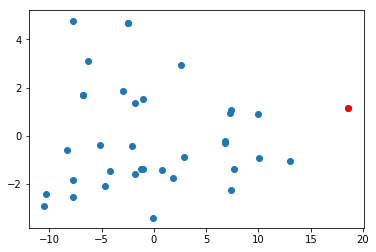

In [237]:
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
X = np.array(df)
pca = PCA(n_components=2)
pca.fit(X)

num_pessoa = 3
num_pessoa_1 = num_pessoa+1
if num_pessoa >= len(df_names):
    num_pessoa_1 = num_pessoa
print(df_names[num_pessoa:num_pessoa_1])

reduct = pca.transform(X)
plt.scatter(reduct[:,0],reduct[:,1])

plt.plot(reduct[num_pessoa,0],reduct[num_pessoa,1],'ro')
plt.show()

# print(pca.get_precision())
# print(pca.score_samples(A))
# print(pca.explained_variance_ratio_)  
# print(reduct)
# print(pca.singular_values_)



In [238]:
# df_names

In [239]:
# reduct[29]

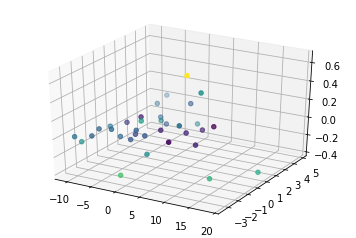

In [240]:
# %matplotlib notebook
from mpl_toolkits import mplot3d
A = np.array(df)
pca = PCA(n_components=3)
pca.fit(A)

# print(pca.get_precision(A))

Areduct = pca.transform(A)

x = Areduct[:,0] 
y = Areduct[:,1]
z = Areduct[:,2]
# c = Areduct[:,3]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=c)
plt.show()

In [206]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array(df)
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
kmeans.labels_

# print(kmeans.predict([[0, 0], [4, 4]]))

# print(kmeans.cluster_centers_)

cluster_2D = kmeans.transform(df)
# plt.scatter(cluster_2D[:,0])
# plt.show()

# cent, var = cluster_2D[3]
# #use vq() to get as assignment for each obs.
# assignment,cdist = cluster.vq.vq(tests,cent)
# pyplot.scatter(tests[:,0], tests[:,1], c=assignment)
# pyplot.show()
# print(cluster_2D)

Cluster 0 contains 8 samples
Cluster 1 contains 8 samples
Cluster 2 contains 7 samples
Cluster 3 contains 2 samples
Cluster 4 contains 11 samples


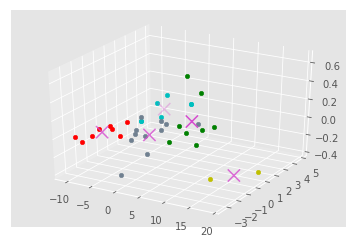

In [267]:
from matplotlib import style
style.use("ggplot")
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

# X = np.array([[1, 2, 5],
#               [5, 8, 2],
#               [1.5, 1.8, 6],
#               [8, 8, 9],
#               [1, 0.6, 10],
#               [2.5, 3.8, 6],
#               [2.5, 5.8, 9],
#               [5, 8, 3],
#               [4, 0.6, 7],
#               [2.5, 1.8, 4.6],
#               [6.5, 1.8, 12],
#               [7, 8, 9],
#               [2, 0.6, 7],
#               [5.5, 1.8, 4],
#               [4.8, 6.9, 6],
#               [4.9, 9.8, 2],
#               [9, 11, 12]])

X = Areduct

cluster_num = 5

kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(Areduct)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# print ("centroids : ",centroids)

# print ("labels : ", labels)


colors = ["g","r","c","y","slategray"]

# color = np.random.rand(cluster_num)

c = Counter(labels)


fig = figure()
ax = fig.gca(projection='3d')


for i in range(len(X)):
#     print("coordinate:",X[i], "label:", labels[i])
#     print ("i : ",i)
#     print ("color[labels[i]] : ",color[labels[i]])
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]]) #color[labels[i]]


for cluster_number in range(cluster_num):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

ax.scatter(centroids[:, 0],centroids[:, 1], centroids[:, 2], marker = "x", s=150, linewidths = 5, zorder = 100, c=color)

plt.show()